In [1]:
import sys
import os
import pickle

# Add the parent directory to sys.path
sys.path.append("/home/jovyan/video-storage/amit_files/image_background_remove_tool")

import torch
device = "cuda" if torch.cuda.is_available else "cpu"

from carvekit.ml.arch.tracerb7.efficientnet import EfficientEncoderB7
from carvekit.ml.wrap.tracer_b7 import TracerUniversalB7

model = TracerUniversalB7()

model = model.to(device)

In [2]:

# Add the parent directory to sys.path
sys.path.append("/home/jovyan/video-storage/amit_files")

!pip install gym

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler

from keypoints.keypoints.data_augments import TpsAndRotate, nop
from keypoints.keypoints.models import keynet
from keypoints.keypoints.utils import ResultsLogger
from keypoints.keypoints.ds import datasets as ds
from keypoints.keypoints.config import config

from keypoints.keypoints.ds.datasets import split

import yaml
from PIL import Image
import argparse
from pathlib import Path
import torch
import json
import numpy as np
from tqdm import tqdm

args_path = '/home/jovyan/video-storage/amit_files/Master_Thesis_Project/keypoints_KTH.yml'

torch.cuda.set_device(0)

args = config(['--config', args_path,'--data_root','/home/jovyan/video-storage/amit_files/Master_Thesis_Project/KTH_Dataset_2/paired_images'])
print(args)

run_dir = f'data/models/keypoints/{args.model_type}/run_{args.run_id}'
run_dir

display = ResultsLogger(run_dir=run_dir,
                            num_keypoints=args.model_keypoints,
                            title = 'Results',
                            visuals = args.display,
                            image_capture_freq = args.display_freq,
                            kp_rows = args.display_kp_rows,
                            comment = args.comment)
display.header(args)



2025-04-09 16:32:07.036219: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 16:32:08.021075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Namespace(device=device(type='cuda', index=0), run_id=64, comment=None, demo=False, load=None, transfer_load=None, checkpoint_freq=1000, data_root='/home/jovyan/video-storage/amit_files/Master_Thesis_Project/KTH_Dataset_2/paired_images', config='/home/jovyan/video-storage/amit_files/Master_Thesis_Project/keypoints_KTH.yml', epochs=24, processes=7, seed=None, cma_algo=None, cma_step_mode='auto', cma_step_decay=0.001, cma_initial_step_size=None, cma_samples=None, cma_oversample=0, display=False, display_freq=5000, display_kp_rows=4, opt_level='O2', model_type='F', model_in_channels=3, model_keypoints=10, transporter_combine_mode='max', policy_action_select_mode='argmax', policy_depth=1, gym_reward_count_limit=None, optimizer='Adam', batch_size=16, lr=None, dataset=None, dataset_train_len=34000, dataset_test_len=274, dataset_randomize=False, data_aug_tps_cntl_pts=4, data_aug_tps_variance=0.05, data_aug_max_rotate=0.1, data_aug_type=None, dataset_1='first_images', dataset_2='second_images'

In [3]:

import os
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch

class KthDataset(Dataset):
    def __init__(self, dir1, dir2, model=None, transform=None, shuffle=False):
        self.dir1 = os.path.join(args.data_root, args.dataset_1)
        self.dir2 = os.path.join(args.data_root, args.dataset_2)
        self.transform = transform
        self.model = model
        
        # Get image lists
        self.images1 = sorted(os.listdir(self.dir1))
        self.images2 = sorted(os.listdir(self.dir2))
        
        assert len(self.images1) == len(self.images2), "Both directories must contain the same number of images."
        
        # Create pairs of image paths
        self.image_pairs = list(zip(self.images1, self.images2))
        
        # Shuffle the pairs if requested
        if shuffle:
            random.shuffle(self.image_pairs)
            self.images1, self.images2 = zip(*self.image_pairs)

    def __len__(self):
        return len(self.images1)

    def __getitem__(self, idx):
        img1_path = os.path.join(self.dir1, self.images1[idx])
        img2_path = os.path.join(self.dir2, self.images2[idx])
        
        # Open images
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        img3 = model([img2_path])[0]
        
        # Apply any transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
            
        # Convert grayscale to 3-channel by stacking
        if img1.shape[0] == 1:  # If single channel
            img1 = torch.cat([img1, img1, img1], dim=0)  # Stack channel 3 times
        
        if img2.shape[0] == 1:  # If single channel
            img2 = torch.cat([img2, img2, img2], dim=0)  # Stack channel 3 times

        # if img3.shape[0] == 1:  # If single channel
        #     img3 = torch.cat([img3, img3, img3], dim=0)  # Stack channel 3 times
        
        return img1, img2, img3

def split(dataset, train_len, test_len):
    """
    Split a dataset into training and testing subsets.
    """
    assert train_len + test_len <= len(dataset), "Sum of train and test lengths exceeds dataset size"
    
    train_dataset, test_dataset = random_split(
        dataset, 
        [train_len, test_len],
        generator=torch.Generator().manual_seed(42)
    )
    
    return train_dataset, test_dataset


pin_memory = False if args.device == 'cpu' else True

# Define your transformation
Kth_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.resize((img.size[0], img.size[1]), resample=Image.LANCZOS)),
    transforms.ToTensor(),
])

# Create the dataset with shuffling
dataset = KthDataset(
    args.dataset_1, 
    args.dataset_2, 
    model=None, 
    transform = Kth_transform,
    shuffle=True  # Enable shuffling at dataset creation
)

# Split into train and test
train_dataset, test_dataset = split(dataset, args.dataset_train_len, args.dataset_test_len)


# Create DataLoaders with additional shuffling
train_loader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,  # Shuffle again during training
    drop_last=True,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    shuffle=False,  # No need to shuffle test data
    drop_last=True,
    pin_memory=True
)


In [20]:
""" model """
kp_network = keynet.make(args).to(args.device)

print(kp_network)

optim = Adam(kp_network.parameters(), lr=1e-4)

""" data augmentation """
if args.data_aug_type == 'tps_and_rotate':
    augment = TpsAndRotate(args.data_aug_tps_cntl_pts, args.data_aug_tps_variance, args.data_aug_max_rotate)
else:
    augment = nop

import matplotlib.pyplot as plt
scaler = GradScaler()
threshold = 0.5

# # loss function
# def l2_reconstruction_loss(x, x_, loss_mask=None):
#     loss = (x - x_) ** 2
#     if loss_mask is not None:
#         loss = loss * loss_mask
#     return torch.mean(loss)


def l2_reconstruction_loss(x, x_, foreground_mask=None, epsilon=1e-6):
    device = x.device
    x_ = x_.to(device)
    pixel_loss = (x - x_) ** 2  # [B, C, H, W]

    if foreground_mask is not None:
        if isinstance(foreground_mask, list):
            if all(isinstance(mask, Image.Image) for mask in foreground_mask):
                foreground_mask = [
                    torch.tensor(np.array(mask), dtype=torch.float32) for mask in foreground_mask
                ]
                foreground_mask = torch.stack(foreground_mask, dim=0)
            else:
                raise ValueError("All elements in foreground_mask list must be PIL Images.")

        foreground_mask = foreground_mask.to(device)

        if len(foreground_mask.shape) == 3:
            foreground_mask = foreground_mask.unsqueeze(1)  # [B, 1, H, W]

        # Broadcast mask to all channels
        foreground_mask = foreground_mask.repeat(1, pixel_loss.shape[1], 1, 1)  # [B, C, H, W]

        if foreground_mask.shape != pixel_loss.shape:
            raise ValueError(f"Foreground mask shape {foreground_mask.shape} does not match loss shape {pixel_loss.shape}")

        # Calculate weighting factor - higher weight for foreground regions
        weight = 1.0 / torch.clamp(1.0 - foreground_mask, min=epsilon)
        
        # Apply weighting to loss
        weighted_loss = pixel_loss * weight
        
        # To maintain reasonable scale, divide by mean weight
        return weighted_loss.mean() / weight.mean()

    return pixel_loss.mean()



criterion = l2_reconstruction_loss

def to_device(data, device):
    return tuple([x.to(device) for x in data])



KeyNet(
  (encoder): Unit(
    (in_block): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (core): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReplicationPad2d((1, 1, 1, 1))
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
      (9): ReplicationPad2d((1, 1, 1, 1))
      (10): Conv2d(256, 256, kern

In [21]:

# Initialize lists to store losses for each epoch
train_losses = []
val_losses = []

# Initialize the loss file before training
loss_file_path = run_dir + '/losses.json'
with open(loss_file_path, 'w') as f:
    json.dump({'train_losses': [], 'val_losses': []}, f)

# Main training loop
for epoch in tqdm(range(0, args.epochs)):
    epoch_train_loss = 0
    epoch_val_loss = 0
    num_train_batches = 0
    num_val_batches = 0

    if not args.demo:
        # Training
        batch = tqdm(train_loader, total=len(train_dataset) // args.batch_size)
        for i, data in enumerate(batch):
            data = to_device(data, device=args.device)
            x, x_ ,foreground_mask = data[0].to(args.device), data[1].to(args.device), data[2].to(args.device)
            
            optim.zero_grad()

            # Mixed precision forward pass
            with autocast():
                x_t, z, k, m, p, heatmap = kp_network(x, x_)
                loss = criterion(x_t, x_,foreground_mask = foreground_mask)
                epoch_train_loss += loss.item()
                num_train_batches += 1

            # Scaled backward pass
            scaler.scale(loss).backward()
            scaler.step(optim)    # Update model parameters
            scaler.update()       # Adjust the scale for next iteration

            if i % args.checkpoint_freq == 0:
                kp_network.save(run_dir + '/checkpoint')
                
            display.log(batch, epoch, i, loss, optim, x, x_, x_t, heatmap, k, m, p, loss_mask=None, type='train', depth=20)

    # Calculate average train loss for the epoch
    epoch_train_loss /= max(1, num_train_batches)
    train_losses.append(epoch_train_loss)

    # Validation
    with torch.no_grad():
        batch = tqdm(test_loader, total=len(test_dataset) // args.batch_size)
        for i, data in enumerate(batch):
            data = to_device(data, device=args.device)
            x, x_ ,foreground_mask = data[0].to(args.device), data[1].to(args.device), data[2].to(args.device)

            with autocast():
                x_t, z, k, m, p, heatmap = kp_network(x, x_)
                loss = criterion(x_t, x_,foreground_mask = foreground_mask)
                epoch_val_loss += loss.item()
                num_val_batches += 1

            display.log(batch, epoch, i, loss, optim, x, x_, x_t, heatmap, k, m, p, loss_mask=None, type='test', depth=20)

    # Calculate average validation loss for the epoch
    epoch_val_loss /= max(1, num_val_batches)
    val_losses.append(epoch_val_loss)

    # Save the updated train and val losses after each epoch
    with open(loss_file_path, 'r+') as f:
        loss_data = json.load(f)
        loss_data['train_losses'].append(epoch_train_loss)
        loss_data['val_losses'].append(epoch_val_loss)
        f.seek(0)  # Go to the beginning of the file
        json.dump(loss_data, f, indent=4)  # Write updated data
        f.truncate()  # Remove any leftover data from previous writes

    ave_loss, best_loss = display.end_epoch(epoch, optim)

    # Save if model improved
    if ave_loss <= best_loss and not args.demo:
        kp_network.save(run_dir + '/best')


  0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epoch: 0 LR: 0.0001 train Loss: 1.6545072019100189:   1%|          | 22/2125 [02:29<3:58:29,  6.80s/it]
  0%|          | 0/24 [02:29<?, ?it/s]


KeyboardInterrupt: 

In [6]:
kp_network.decoder.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_62/best/decoder/core.mdl'))
kp_network.decoder.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_62/best/decoder/in_block.mdl'))
kp_network.decoder.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_62/best/decoder/out_block.mdl'))

kp_network.encoder.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_62/best/encoder/core.mdl'))
kp_network.encoder.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_62/best/encoder/in_block.mdl'))
kp_network.encoder.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_62/best/encoder/out_block.mdl'))

kp_network.keypoint.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_62/best/keypoint/core.mdl'))
kp_network.keypoint.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_62/best/keypoint/in_block.mdl'))
kp_network.keypoint.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/Master_Thesis_Project/data/models/keypoints/F/run_62/best/keypoint/out_block.mdl'))

# 48

kp_network.eval()

KeyNet(
  (encoder): Unit(
    (in_block): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (core): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReplicationPad2d((1, 1, 1, 1))
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
      (9): ReplicationPad2d((1, 1, 1, 1))
      (10): Conv2d(256, 256, kern

In [7]:
import torch
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as transforms

# Assuming color_map function is defined like this:
def color_map(num_colors=20):
    # Generate a color map with 'num_colors' unique colors
    return np.random.randint(0, 255, size=(num_colors, 3))

def plot_keypoints_on_image(k, image_tensor, radius=3, thickness=2):
    # Ensure single image and keypoints are provided, not a batch
    if len(k.shape) != 2:
        raise ValueError('Expected keypoints for a single image, not a batch.')

    # Extract image dimensions
    height, width = image_tensor.size(1), image_tensor.size(2)
    num_keypoints = k.size(0)

    # Scale keypoints from normalized to pixel coordinates
    k = k.clone()  # Clone to avoid modifying the original tensor
    k[:, 0] = k[:, 0] * height  # Scale y-coordinate
    k[:, 1] = k[:, 1] * width   # Scale x-coordinate
    k.floor_()                  # Round down to the nearest integer
    k = k.detach().cpu().numpy()  # Convert to NumPy for OpenCV

    # Convert the image tensor to a PIL image, then to a NumPy array
    img = transforms.ToPILImage()(image_tensor.cpu())
    img = np.array(img)

    # Generate color map and plot each keypoint
    cm = color_map(num_keypoints)  # Create color map for each keypoint
    for co_ord, color in zip(k, cm):
        color = tuple(color.astype(int).tolist())  # Convert to tuple of int RGB values
        co_ord = co_ord.squeeze().astype(int)      # Ensure coordinates are integers
        cv2.circle(img, (co_ord[1], co_ord[0]), radius, color, thickness)

    return img


In [8]:
def plot_corresponding_images(tensor1, tensor2, tensor3, k):
    """
    Plots corresponding images from three tensors in a 16-row grid with 3 columns.
    
    Parameters:
    - tensor1 (torch.Tensor): First tensor of shape (16, 3, 16, 16).
    - tensor2 (torch.Tensor): Second tensor of shape (16, 3, 16, 16).
    - tensor3 (torch.Tensor): Third tensor of shape (16, 3, 16, 16).
    """
    # np.transpose(array, (1, 0, 2))
    tensor1 = tensor1.detach().cpu().numpy()
    tensor2 = tensor2.detach().cpu().numpy()
    tensor3 = tensor3.detach().cpu().numpy()

    # images = []
    # for i in range(0,k.shape[0]):
    #     img = plot_keypoints_on_image(k[i],tensor3[i])
    #     images.append(img)

    # tensor3 = np.asarray(images)
    
    batch_size = tensor1.shape[0]  # Expected to be 16
    num_cols = 3  # Since we have 3 tensors
    num_rows = batch_size  # Each row will represent one set of corresponding images

    # Set up the figure and axis grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    fig.suptitle("Corresponding Images from Three Tensors", fontsize=16)

    # Loop through each batch item and plot the corresponding images
    for i in range(batch_size):
        # Tensor 1 image
        image1 = np.transpose(tensor1[i], (1, 2, 0))  # (3, 16, 16) -> (16, 16, 3)
        axes[i, 0].imshow(image1)
        axes[i, 0].axis("off")
        axes[i, 0].set_title(f"original Img {i+1}")

        # Tensor 2 image
        image2 = np.transpose(tensor2[i], (1, 2, 0))
        axes[i, 1].imshow(image2)
        axes[i, 1].axis("off")
        axes[i, 1].set_title(f"Affine Transformed - Img {i+1}")

        # Tensor 3 image
        # image3 = tensor3[i]
        image3 = np.transpose(tensor3[i], (1, 2, 0))
        axes[i, 2].imshow(image3)
        axes[i, 2].axis("off")
        axes[i, 2].set_title(f"Reconstructed Img {i+1}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust to make room for title
    plt.show()

In [9]:
def plot_corresponding_images4(tensor1, tensor2, tensor3,k):
    temp = tensor1
    
    # np.transpose(array, (1, 0, 2))
    tensor1 = tensor1.detach().cpu().numpy()
    tensor2 = tensor2.detach().cpu().numpy()
    
    images = []
    images2 = []
    
    for i in range(0,k.shape[0]):
        img = plot_keypoints_on_image(k[i],tensor3[i])
        img1 = plot_keypoints_on_image(k[i],temp[i])
        images.append(img)
        images2.append(img1)
    
    tensor3 = np.asarray(images)
    tensor4 = np.asarray(images2)
    
    batch_size = tensor1.shape[0]  # Expected to be 16
    num_cols = 4  # Since we have 4 tensors
    num_rows = batch_size  # Each row will represent one set of corresponding images

    # Set up the figure and axis grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    fig.suptitle("Corresponding Images from Three Tensors", fontsize=16)

    # Loop through each batch item and plot the corresponding images
    for i in range(batch_size):
        # Tensor 1 image
        image1 = np.transpose(tensor1[i], (1, 2, 0))  # (3, 16, 16) -> (16, 16, 3)
        axes[i, 0].imshow(image1)
        axes[i, 0].axis("off")
        axes[i, 0].set_title(f"original Img {i+1}")

        # Tensor 2 image
        image2 = np.transpose(tensor2[i], (1, 2, 0))
        axes[i, 1].imshow(image2)
        axes[i, 1].axis("off")
        axes[i, 1].set_title(f"Affine Transformed - Img {i+1}")

        # Tensor 3 image
        image3 = tensor3[i]
        axes[i, 2].imshow(image3)
        axes[i, 2].axis("off")
        axes[i, 2].set_title(f"Reconstructed Img on Aff Trans{i+1}")

        # Tensor 4 image
        image4 = tensor4[i]
        axes[i, 3].imshow(image4)
        axes[i, 3].axis("off")
        axes[i, 3].set_title(f"Reconstructed Img on org Img{i+1}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust to make room for title
    plt.show()

In [10]:
import matplotlib.pyplot as plt
import torch

def plot_tensor_images(tensor):
    # Ensure the tensor has the expected shape
    assert tensor.shape[1] == 3, "Expected 3 channels for RGB images"
    tensor = tensor.detach().cpu().numpy()

    # Convert tensor to numpy
    images = np.transpose(tensor, (0, 2, 3, 1))  # Shape (16, 16, 16, 3)

    # Plot the images in a 4x4 grid
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i]
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [11]:
import torch
import numpy as np
from tqdm import tqdm
from skimage.color import rgb2gray
from skimage.filters import sobel
from scipy.ndimage import gaussian_filter
from torch.cuda.amp import autocast

# Function to compute saliency map for a single image
def compute_saliency_map(img):
    # Ensure img is in correct range and format for skimage
    if img.shape[-1] != 3:
        raise ValueError("Expected RGB image with channels last")
    
    # Convert to grayscale
    gray = rgb2gray(img)
    
    # Compute edge map using Sobel filter
    edge_map = sobel(gray)
    
    # Apply Gaussian smoothing to get saliency map
    saliency_map = gaussian_filter(edge_map, sigma=3)
    
    return saliency_map

# Function to compute VSI between two images
def compute_vsi(img1, img2):
    try:
        # Compute saliency maps
        sal1 = compute_saliency_map(img1)
        sal2 = compute_saliency_map(img2)
        
        # Normalize saliency maps
        sal1 = sal1 / (np.max(sal1) + 1e-8)
        sal2 = sal2 / (np.max(sal2) + 1e-8)
        
        # Compute similarity map (similar to SSIM local formula)
        similarity = (2 * sal1 * sal2 + 1e-8) / (sal1**2 + sal2**2 + 1e-8)
        
        # Use average saliency for weighting
        weight_map = (sal1 + sal2) / 2
        
        # Compute final VSI score
        vsi = np.sum(similarity * weight_map) / (np.sum(weight_map) + 1e-8)
        
        return vsi
    except Exception as e:
        print(f"Error computing VSI for image: {e}")
        return 0.0  # Return a default value on error

# Helper function to move tensors to device
def to_device(data, device):
    if isinstance(data, torch.Tensor):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        return {k: to_device(v, device) for k, v in data.items()}
    else:
        return data

# Initialize variables to track total VSI and number of images
total_vsi = 0
num_images = 0

# Validation loop
for epoch in tqdm(range(0, 1)):
    with torch.no_grad():
        batch = tqdm(test_loader, total=len(test_dataset) // args.batch_size)
        for batch_idx, data in enumerate(batch):
            # Move data to device
            data = to_device(data, device=args.device)
            
            # Extract input and target images
            x, x_ = data[0], data[1]
            
            with autocast():
                # Forward pass through your keypoint network
                x_t, z, k, m, p, heatmap = kp_network(x, x_)
                
                # Convert tensors to numpy arrays
                images_np = x_.cpu().numpy().transpose(0, 2, 3, 1)  # (B, H, W, C)
                reconstructed_np = x_t.cpu().numpy().transpose(0, 2, 3, 1)
                
                # Ensure pixel values are in range [0, 1]
                images_np = np.clip(images_np, 0, 1)
                reconstructed_np = np.clip(reconstructed_np, 0, 1)
                
                # Compute VSI for each image in the batch
                for i in range(images_np.shape[0]):
                    try:
                        vsi_value = compute_vsi(images_np[i], reconstructed_np[i])
                        total_vsi += vsi_value
                        num_images += 1
                        
                        # Optional: print per-image VSI for debugging
                        if batch_idx == 0 and i == 0:
                            print(f"Sample VSI value: {vsi_value:.4f}")
                            
                    except Exception as e:
                        print(f"Error processing image {i} in batch {batch_idx}: {e}")
    break  # Only process one epoch

# Compute average VSI across all images
if num_images > 0:
    average_vsi = total_vsi / num_images
    print(f"Average Visual Saliency Index (VSI) on test dataset: {average_vsi:.4f}")
else:
    print("No images were successfully processed.")

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Sample VSI value: 0.7108


  0%|          | 0/1 [05:34<?, ?it/s]

Average Visual Saliency Index (VSI) on test dataset: 0.6431


In [12]:
import torch
import numpy as np
import cv2
from torchvision.utils import make_grid

# PSNR Calculation Function
def compute_psnr(img1, img2):
    """Computes PSNR between two images (NumPy format)."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  # Perfect match
    max_pixel = 1.0  # Assuming images are normalized in [0,1]
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value


In [13]:

# Testing DataLoader (Assuming you have already created test_loader)
total_psnr = 0
num_images = 0

# Validation
for epoch in tqdm(range(0, 1)):
    with torch.no_grad():
        batch = tqdm(test_loader, total=len(test_dataset) // args.batch_size)
        for i, data in enumerate(batch):
            data = to_device(data, device=args.device)
            x, x_,foreground_mask = data[0].to(args.device), data[1].to(args.device),data[2].to(args.device)
            with autocast():
                x_t, z, k, m, p, heatmap = kp_network(data[0], x_)
                # plot_corresponding_images(x, x_, x_t,k)
                images_np = x_.cpu().numpy().transpose(0, 2, 3, 1)  # (B, H, W, C)
                reconstructed_np = x_t.cpu().numpy().transpose(0, 2, 3, 1)
                reconstructed_np = np.clip(reconstructed_np, 0, 1)
                images_np = np.clip(images_np, 0, 1)

                for i in range(images_np.shape[0]):
                    psnr_value = compute_psnr(images_np[i], reconstructed_np[i])
                    total_psnr += psnr_value
                    num_images += 1
    break
            

# Compute Average PSNR
average_psnr = total_psnr / num_images
print(f"Average PSNR on test dataset: {average_psnr:.2f} dB")
# 27.71

  0%|          | 0/1 [04:24<?, ?it/s]

Average PSNR on test dataset: 10.03 dB


In [14]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Function to compute SSIM
def compute_ssim(img1, img2):
    """Computes SSIM between two images (NumPy format)."""
    return ssim(img1, img2, data_range=1.0, channel_axis=-1)  # Ensure range is [0,1]

# Initialize SSIM calculation
total_ssim = 0
num_images = 0

# Validation
for epoch in tqdm(range(0, 1)):
    with torch.no_grad():
        batch = tqdm(test_loader, total=len(test_dataset) // args.batch_size)
        for i, data in enumerate(batch):
            data = to_device(data, device=args.device)
            x, x_,foreground_mask = data[0].to(args.device), data[1].to(args.device),data[2].to(args.device)

            with autocast():
                x_t, z, k, m, p, heatmap = kp_network(data[0], x_)
                # plot_corresponding_images(x, x_, x_t,k)
                images_np = x_.cpu().numpy().transpose(0, 2, 3, 1)  # (B, H, W, C)
                reconstructed_np = x_t.cpu().numpy().transpose(0, 2, 3, 1)
                reconstructed_np = np.clip(reconstructed_np, 0, 1)
                images_np = np.clip(images_np, 0, 1)

                for i in range(images_np.shape[0]):
                    ssim_value = compute_ssim(images_np[i], reconstructed_np[i])
                    total_ssim += ssim_value
                    num_images += 1
    break


# Compute Average SSIM
average_ssim = total_ssim / num_images
print(f"Average SSIM on test dataset: {average_ssim:.4f}")
# 0.7253

  0%|          | 0/1 [01:54<?, ?it/s]

Average SSIM on test dataset: 0.2779


In [15]:
loaded_data = np.load("/home/jovyan/video-storage/amit_files/Master_Thesis_Project/KTH_image_batches.npz", allow_pickle=True)
x_list_loaded = [torch.tensor(arr) for arr in loaded_data["x_list"]]
x_dash_list_loaded = [torch.tensor(arr) for arr in loaded_data["x_dash_list"]]

In [16]:
print(x_list_loaded[0].shape)
print(x_dash_list_loaded[0].shape)

torch.Size([16, 3, 120, 160])
torch.Size([16, 3, 120, 160])


In [17]:
import torch
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import autocast
import math
from skimage.metrics import peak_signal_noise_ratio

# Function to compute PSNR
def compute_psnr(img1, img2):
    try:
        # Using skimage's implementation for reliability
        psnr_value = peak_signal_noise_ratio(img1, img2, data_range=1.0)
        return psnr_value
    except Exception as e:
        print(f"Error computing PSNR: {e}")
        # Alternative manual calculation if skimage fails
        mse = np.mean((img1 - img2) ** 2)
        if mse == 0:
            return 100.0  # Perfect similarity
        return 20 * math.log10(1.0 / math.sqrt(mse))

# Initialize tracking variables
total_psnr = 0
num_images = 0

# Validation loop using your image lists
for ind in tqdm(range(0, len(x_list_loaded))):
    with torch.no_grad():
        with autocast():
            # Get images from your lists
            x = x_list_loaded[ind].to(device="cuda")
            x_ = x_dash_list_loaded[ind].to(device="cuda")
            
            # Forward pass through your model
            x_t, z, k, m, p, heatmap = kp_network(x, x_)
            
            # Convert tensors to numpy arrays for PSNR computation
            # Add batch dimension if needed
            if len(x_.shape) == 3:  # Add batch dimension if missing
                x_ = x_.unsqueeze(0)
                x_t = x_t.unsqueeze(0)
            
            # Convert to numpy and transpose to channel-last format
            x_np = x_.cpu().numpy().transpose(0, 2, 3, 1)  # [B, H, W, C]
            x_t_np = x_t.cpu().numpy().transpose(0, 2, 3, 1) 
            
            # Ensure pixel values are in range [0, 1]
            x_np = np.clip(x_np, 0, 1)
            x_t_np = np.clip(x_t_np, 0, 1)
            
            # Compute PSNR for each image in batch
            for i in range(x_np.shape[0]):
                psnr_value = compute_psnr(x_np[i], x_t_np[i])
                total_psnr += psnr_value
                num_images += 1
                
                # Print individual PSNR for first few images
                if ind < 5:
                    print(f"Image {ind}, Batch item {i}: PSNR = {psnr_value:.2f} dB")
            
    
    # Uncomment if you want to process only one batch
    # break

# Calculate and print average PSNR
if num_images > 0:
    average_psnr = total_psnr / num_images
    print(f"Average PSNR: {average_psnr:.2f} dB")
    print(f"Processed {num_images} images total")
else:
    print("No images were successfully processed for PSNR calculation.")

100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

Image 0, Batch item 0: PSNR = 10.99 dB
Image 0, Batch item 1: PSNR = 6.86 dB
Image 0, Batch item 2: PSNR = 9.80 dB
Image 0, Batch item 3: PSNR = 10.45 dB
Image 0, Batch item 4: PSNR = 10.10 dB
Image 0, Batch item 5: PSNR = 10.01 dB
Image 0, Batch item 6: PSNR = 10.90 dB
Image 0, Batch item 7: PSNR = 11.76 dB
Image 0, Batch item 8: PSNR = 10.68 dB
Image 0, Batch item 9: PSNR = 10.66 dB
Image 0, Batch item 10: PSNR = 6.48 dB
Image 0, Batch item 11: PSNR = 11.34 dB
Image 0, Batch item 12: PSNR = 9.96 dB
Image 0, Batch item 13: PSNR = 6.43 dB
Image 0, Batch item 14: PSNR = 10.93 dB
Image 0, Batch item 15: PSNR = 11.43 dB
Average PSNR: 9.92 dB
Processed 16 images total


In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import autocast
from skimage.metrics import structural_similarity as ssim

# Function to compute SSIM
def compute_ssim(img1, img2):
    try:
        # For multi-channel images (RGB)
        if img1.shape[-1] == 3:
            # Calculate SSIM for multi-channel image
            ssim_value = ssim(img1, img2, channel_axis=-1, data_range=1.0)
        else:
            # For grayscale images
            ssim_value = ssim(img1, img2, data_range=1.0)
        return ssim_value
    except Exception as e:
        print(f"Error computing SSIM: {e}")
        return 0.0

# Initialize tracking variables
total_ssim = 0
num_images = 0

# Validation loop using your image lists
for ind in tqdm(range(0, len(x_list_loaded))):
    with torch.no_grad():
        with autocast():
            # Get images from your lists
            x = x_list_loaded[ind].to(device="cuda")
            x_ = x_dash_list_loaded[ind].to(device="cuda")
            
            # Forward pass through your model
            x_t, z, k, m, p, heatmap = kp_network(x, x_)
            
            # Convert tensors to numpy arrays for SSIM computation
            # Add batch dimension if needed
            if len(x_.shape) == 3:  # Add batch dimension if missing
                x_ = x_.unsqueeze(0)
                x_t = x_t.unsqueeze(0)
            
            # Convert to numpy and transpose to channel-last format
            x_np = x_.cpu().numpy().transpose(0, 2, 3, 1)  # [B, H, W, C]
            x_t_np = x_t.cpu().numpy().transpose(0, 2, 3, 1) 
            
            # Ensure pixel values are in range [0, 1]
            x_np = np.clip(x_np, 0, 1)
            x_t_np = np.clip(x_t_np, 0, 1)
            
            # Compute SSIM for each image in batch
            for i in range(x_np.shape[0]):
                ssim_value = compute_ssim(x_np[i], x_t_np[i])
                total_ssim += ssim_value
                num_images += 1
                
                # Print individual SSIM for first few images
                if ind < 5:
                    print(f"Image {ind}, Batch item {i}: SSIM = {ssim_value:.4f}")
            
    # Uncomment if you want to process only one batch
    # break

# Calculate and print average SSIM
if num_images > 0:
    average_ssim = total_ssim / num_images
    print(f"Average SSIM: {average_ssim:.4f}")
    print(f"Processed {num_images} images total")
else:
    print("No images were successfully processed for SSIM calculation.")

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from skimage.color import rgb2gray
from skimage.filters import sobel
from scipy.ndimage import gaussian_filter
from torch.cuda.amp import autocast

# Function to compute saliency map for a single image
def compute_saliency_map(img):
    # Ensure img is in correct range and format for skimage
    if img.shape[-1] != 3:
        raise ValueError("Expected RGB image with channels last")
    
    # Convert to grayscale
    gray = rgb2gray(img)
    
    # Compute edge map using Sobel filter
    edge_map = sobel(gray)
    
    # Apply Gaussian smoothing to get saliency map
    saliency_map = gaussian_filter(edge_map, sigma=3)
    
    return saliency_map

# Function to compute VSI between two images
def compute_vsi(img1, img2):
    try:
        # Compute saliency maps
        sal1 = compute_saliency_map(img1)
        sal2 = compute_saliency_map(img2)
        
        # Normalize saliency maps
        sal1 = sal1 / (np.max(sal1) + 1e-8)
        sal2 = sal2 / (np.max(sal2) + 1e-8)
        
        # Compute similarity map
        similarity = (2 * sal1 * sal2 + 1e-8) / (sal1**2 + sal2**2 + 1e-8)
        
        # Use average saliency for weighting
        weight_map = (sal1 + sal2) / 2
        
        # Compute final VSI score
        vsi = np.sum(similarity * weight_map) / (np.sum(weight_map) + 1e-8)
        
        return vsi
    except Exception as e:
        print(f"Error computing VSI: {e}")
        return 0.0

# Initialize VSI tracking
total_vsi = 0
num_images = 0

# Validation loop using your image lists
for ind in tqdm(range(0, len(x_list_loaded))):
    with torch.no_grad():
        with autocast():
            # Get images from your lists
            x = x_list_loaded[ind].to(device="cuda")
            x_ = x_dash_list_loaded[ind].to(device="cuda")
            
            # Forward pass through your model
            x_t, z, k, m, p, heatmap = kp_network(x, x_)
            
            # Convert tensors to numpy arrays for VSI computation
            # Add batch dimension if needed
            if len(x_.shape) == 3:  # Add batch dimension if missing
                x_ = x_.unsqueeze(0)
                x_t = x_t.unsqueeze(0)
            
            # Convert to numpy and transpose to channel-last format
            x_np = x_.cpu().numpy().transpose(0, 2, 3, 1)  # [B, H, W, C]
            x_t_np = x_t.cpu().numpy().transpose(0, 2, 3, 1) 
            
            # Ensure pixel values are in range [0, 1]
            x_np = np.clip(x_np, 0, 1)
            x_t_np = np.clip(x_t_np, 0, 1)
            
            # Compute VSI for each image in batch
            for i in range(x_np.shape[0]):
                vsi_value = compute_vsi(x_np[i], x_t_np[i])
                total_vsi += vsi_value
                num_images += 1
                
                # Print individual VSI for first few images
                if ind < 5:
                    print(f"Image {ind}, Batch item {i}: VSI = {vsi_value:.4f}")
            
    
    # Uncomment if you want to process only one batch
    # break

# Calculate and print average VSI
if num_images > 0:
    average_vsi = total_vsi / num_images
    print(f"Average Visual Saliency Index (VSI): {average_vsi:.4f}")
    print(f"Processed {num_images} images total")
else:
    print("No images were successfully processed for VSI calculation.")

  0%|          | 0/1 [00:00<?, ?it/s]

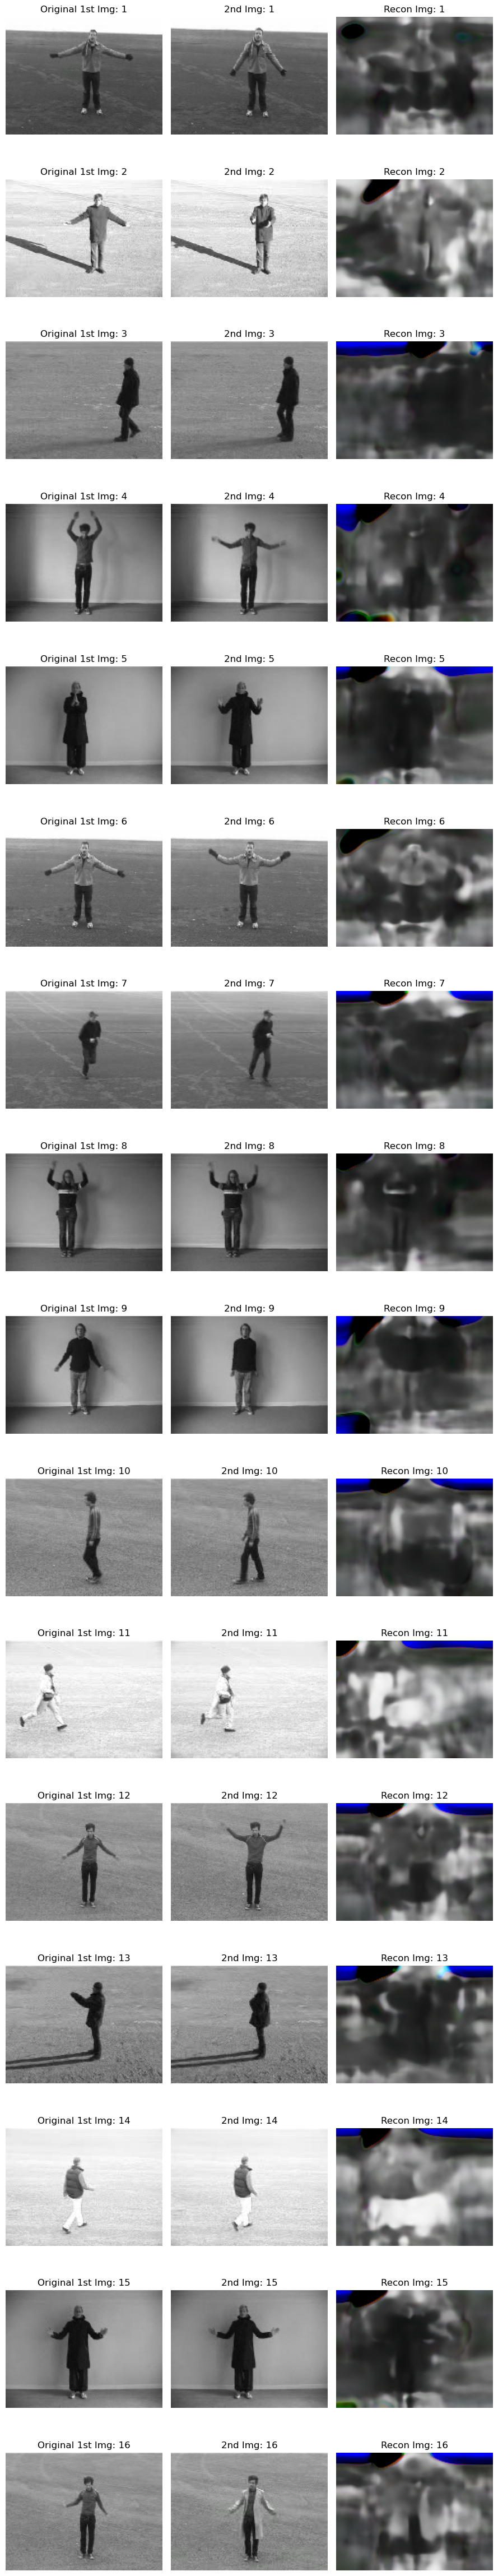

  0%|          | 0/1 [00:13<?, ?it/s]


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast

def plot_corresponding_imagesKey(tensor1, tensor2, tensor3, k=None):
    tensor1 = tensor1.detach().cpu().numpy()
    tensor2 = tensor2.detach().cpu().numpy()
    tensor3 = tensor3.detach().cpu().numpy()

    batch_size = tensor1.shape[0]
    num_cols = 3
    num_rows = batch_size

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(batch_size):
        for j, tensor in enumerate([tensor1, tensor2, tensor3]):
            image = np.transpose(tensor[i], (1, 2, 0)).astype(np.float32)  # Ensure float32
            image = np.clip(image, 0, 1)

            ax = axes[i, j]
            ax.imshow(image)
            ax.axis("off")

            if j == 0:
                ax.set_title(f"Original 1st Img: {i+1}")
            elif j == 1:
                ax.set_title(f"2nd Img: {i+1}")
            else:
                ax.set_title(f"Recon Img: {i+1}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.97)
    plt.show()


# ---------- Run inference and plot ----------
for ind in tqdm(range(0, len(x_list_loaded))):
    with autocast():
        x = x_list_loaded[ind].to(device="cuda")
        x_ = x_dash_list_loaded[ind].to(device="cuda")
        x_t, z, k, m, p, heatmap = kp_network(x, x_)

    # Plot the result
    plot_corresponding_imagesKey(x, x_, x_t, k)
    break  # Remove this if you want to plot more batches
